In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
from matplotlib.pyplot import figure
from matplotlib.animation import FFMpegWriter

In [5]:
#tamanho (linear) da malha (a priori)
N = 18**2

In [6]:
def cria_malhas(N,tipo):
    malha = np.zeros((N,N))
    if tipo == 1:
        #malha trivial com todos os spins positivos
        for i in range(N):
            for j in range(N):
                malha[i][j] = 1
    elif tipo == 2:
        #malha trivial com todos os spins negativos
        for i in range(N):
            for j in range(N):
                malha[i][j] = -1
    elif tipo == 3:
        #malha 25% dos spins positivos (e 75% dos spins negativos)
        init_random = np.random.random((N,N))
        malha[init_random <= 0.25] = 1
        malha[init_random >= 0.25] = -1
    elif tipo == 4:
        #malha 75% dos spins positivos (e 25% dos spins negativos)
        init_random = np.random.random((N,N))
        malha[init_random <= 0.75] = 1
        malha[init_random >= 0.75] = -1
    elif tipo == 5:
        #malha completamente randomica
        init_random = np.random.random((N,N))
        prob = np.random.random()
        malha[init_random <= prob] = 1
        malha[init_random >= prob] = -1
    return malha

In [7]:
#aqui foi desconsiderado as condições de contorno (i.e., fazer o toro)
def get_energy(malha):
    # soma entre os vizinhos próximos
    kern = generate_binary_structure(2,1)
    kern[1][1] = False
    arr = - malha * convolve(malha, kern, mode='constant') #convolução
    return arr.sum()

In [8]:
@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        #pega um ponto aleatório na malha e troca o spin
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] #spin inicial
        spin_f = spin_i*-1 #possível spin final
        
        #mudança na energia
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        
        #muda o estado de acordo com as probabilidades do modelo de Ising 
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
            
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
            
    return net_spins, net_energy

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [9]:
@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [125]:
def mostrarResultados(malha, malhaL, spins, energies, beta):
    bfig, axes = plt.subplots(2, 2, figsize=(30,10))
    axes[1][0].imshow(malha)
    axes[1][1].imshow(malhaL)
    ax = axes[0][0]
    ax.plot(spins)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel('Magnetização Média')
    ax.grid()
    ax = axes[0][1]
    ax.plot(energies)
    ax.set_xlabel('Passos de Monte Carlo')
    ax.set_ylabel(r'Energia $E/J$')
    ax.grid()
    bfig.tight_layout()
    bfig.suptitle(f"Magnetização Média e Energia para beta * J = {beta}",  y=1.07, size=50)
    #bfig.suptitle("Antes ---------------------------------------------------- Depois",  y=0, size=50)
    plt.show()

In [10]:
def main(N, tipo, BJ, passosMC):
    malha = cria_malhas(N, tipo)
    get_energy(malha)
    spins, energies = metropolis(malha, passosMC, BJ, get_energy(malha))
    return malha, spins, energies

<font size="5"> Exemplo do uso do algoritmo de metropolis: </font>

In [102]:
malhaExpl = cria_malhas(N,5)  
betaJ = 0.5
passosMC = 1e6

spinsExpl, energiesExpl = metropolis(malhaExpl, passosMC, betaJ, get_energy(malhaExpl))
malhaApos = metropolisArr(malhaExpl, passosMC, betaJ, get_energy(malhaExpl))

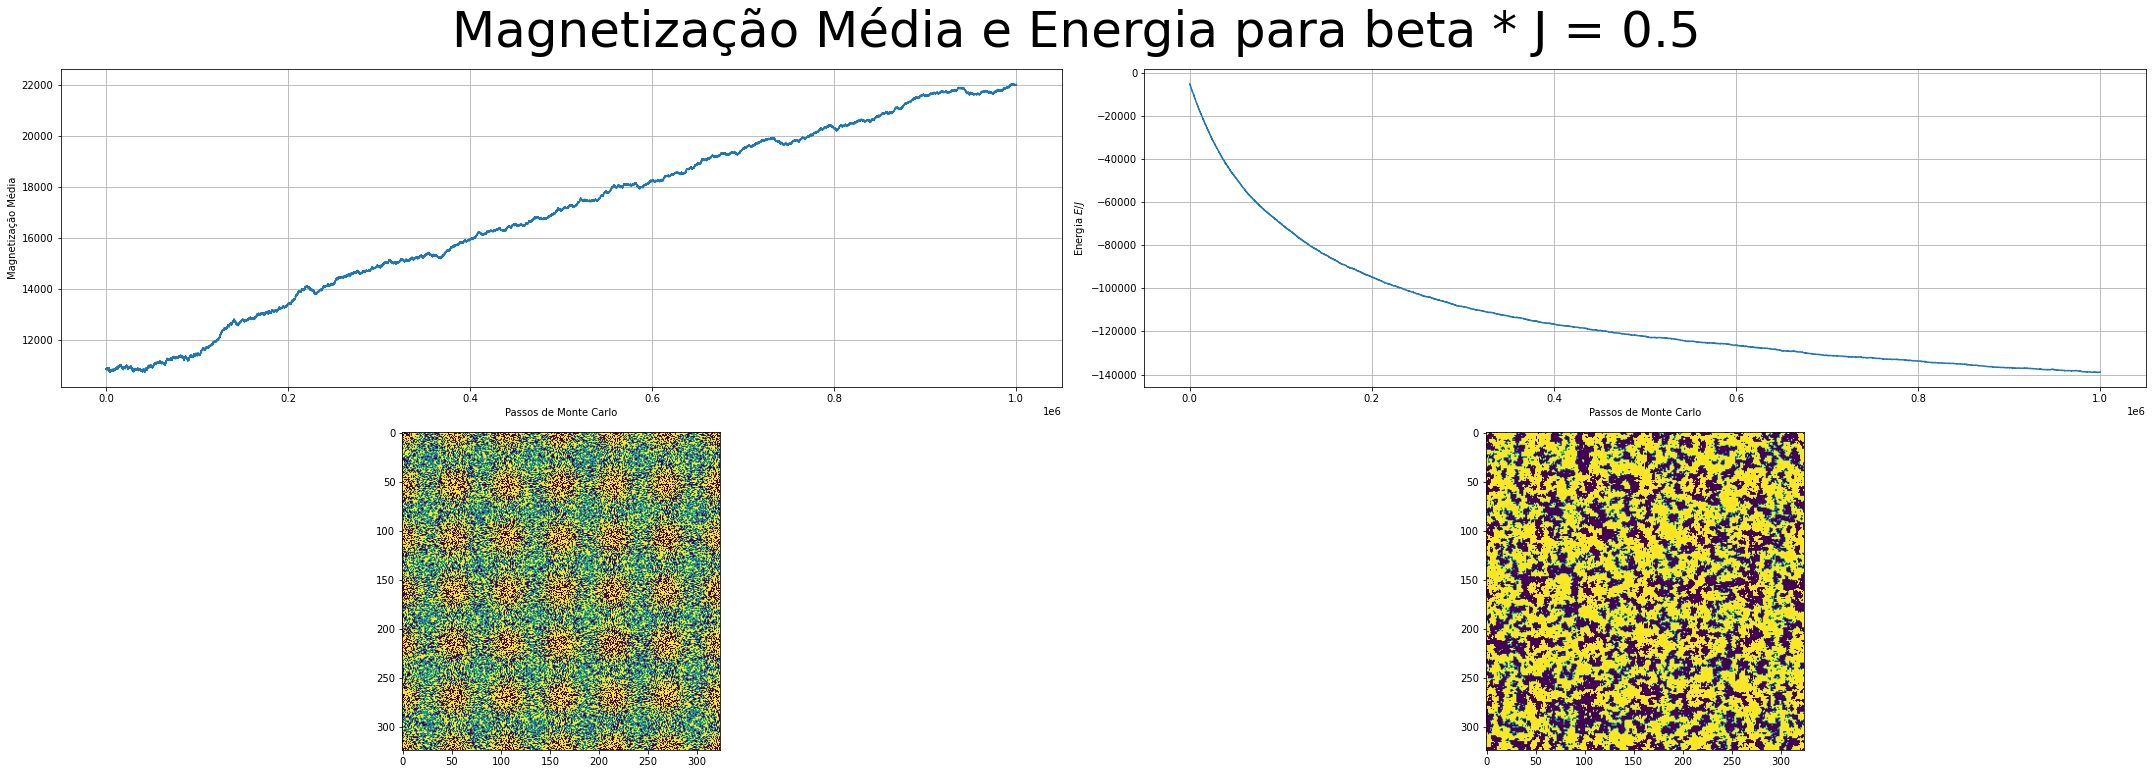

In [126]:
mostrarResultados(malhaExpl, malhaApos, spinsExpl, energiesExpl, betaJ)

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $18^2$: </font>

In [104]:
tipo = 5 #tipo para criação de malhas: aleatório
N = 18**2 #tamanho da rede
n = 10 #tamanho da caixa
passosMC = 1.1e5 #quantidade de passos MC
BJs = np.arange(2, 3.1, 0.1) #array de 1/temperaturas BJ's 

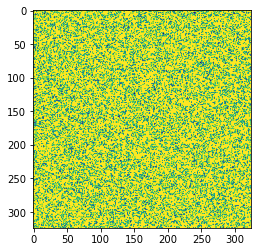

In [105]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)

<font size="5"> Matrizes para as magnetizações, energias, calores específicos e susceptibilidade magnética tal que cada linha corresponda a uma temperatura BJ fixa e as colunas, então, representam o valor médio na caixa correspondente. </font>


In [106]:
ms = np.zeros((len(BJs),n))
Es = np.zeros((len(BJs),n))
Cvs = np.zeros((len(BJs),n))
chis = np.zeros((len(BJs),n))

In [107]:
for i, bj in enumerate(reversed(BJs)):  # i ira indexar as linhas a uma temperatura fixa bj

#Ao modificar a temperatura, utilize como configuração inicial da nova temperatura a última
#configuração gerada na temperatura anterior, ou seja, as configurações serão alteradas apenas
#pelo processo de Monte Carlo
    
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    
    #print(i,bj)
    
    for caixas in reversed(range(n)): 
        #estamos a uma temperatura BJ fixa (=> a  uma linha i fixa)
        #percorremos as colunas,i.e., as caixas
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
        # divide os últimos 1e5 pontos, suposto atingido a termalização, em caixas de tamanho
        # 1e4, e cada termo ms[i][caixas] eh a media dos spins nessa caixa a temperatura i
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [108]:
print(f"{ms}\n{Es}\n{Cvs}\n{chis}")

[[ 86396.7888  85254.0894  84117.0162  82793.9618  81417.4838  80011.623
   78618.021   77209.8306  75866.8514  74486.1856]
 [ 95905.5232  95264.4542  94631.4678  93968.8578  93203.4738  92372.8896
   91514.1938  90558.7828  89654.1452  88728.0674]
 [100545.7758 100262.1632  99939.3888  99620.125   99262.6422  98884.7804
   98482.1154  98045.4012  97593.52    97081.6632]
 [102889.6862 102732.98   102570.2522 102434.8682 102262.578  102080.0996
  101851.3884 101613.0946 101389.5266 101152.203 ]
 [103914.9234 103854.4118 103779.3596 103714.364  103645.3148 103559.1878
  103471.3128 103384.617  103271.1032 103152.8562]
 [104524.3722 104495.8066 104467.2962 104424.4276 104390.0406 104355.4958
  104316.1666 104281.179  104225.3506 104157.1458]
 [104739.9724 104727.0646 104711.2482 104689.9388 104676.1378 104658.8456
  104639.7034 104618.2428 104589.2462 104561.1466]
 [104846.0886 104842.5612 104829.2274 104813.4516 104805.4554 104801.604
  104790.3868 104777.918  104767.7862 104745.859 ]
 [

<font size="5"> Agora, façamos as médias das quantidades pelas caixas em uma temperatura $\beta$ J fixa: </font>

In [109]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

In [110]:
for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean() #temos a media da magnetização nas caixas para cada temperatura BJ
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

In [111]:
print(f"{mBarra}\n{EBarra}\n{CvBarra}\n{chiBarra}")

[ 80617.18516  92580.18556  98971.75752 102097.66768 103574.74506
 104363.7281  104661.15464 104802.03382 104872.12194 104934.49714
 104963.04074]
[-237765.32762 -333455.93546 -377970.71824 -399088.6545  -409488.25024
 -414466.6386  -416381.86532 -417434.26988 -417981.72572 -418333.6146
 -418484.16296]
[5738.74957059 2879.63236834 1543.47676814  810.60826807  399.91410321
  205.98723462  103.91616476   67.10016412   33.82528405   22.07854291
   10.51867194]
[756.38636841 478.89170915 248.85479086 129.55351986  59.82997231
  33.50071105  14.4164667   10.01371398   4.59153003   2.98878563
   0.876556  ]


<font size="5"> Calculamos o erro estatístico de cada quantidade nas n caixas para cada temperatura $\beta J$ fixa: </font>

In [112]:
mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

<font size="5">$$\left( \Delta \overline{C_v} \right)^2 = \frac{\sum_{i=0}^{n-1} \left( \langle C_v \rangle  - C_v[i] \right)}{N \cdot (N-1)}$$ </font>


In [113]:
for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[i] - ms[BJ][i] )**2
        ESoma += ( EBarra[i] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[i] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[i] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

In [114]:
print(f"{mErr}\n{EErr}\n{CvErr}\n{chiErr}")

[7432.9006122  4009.9122718  2809.36289681 2715.47312457 2799.67080175
 2889.11374991 2926.26224688 2945.54501654 2953.70742943 2964.10118855
 2968.18002732]
[53549.43964905 26187.90457128 19229.18178428 19357.35680729
 20325.4527868  20986.73597099 21273.0522902  21441.52500869
 21524.67117636 21583.7622925  21607.39228407]
[1806.43372269  927.97487376  677.92491979  622.12419703  664.07844277
  677.43077931  684.13655819  693.55363368  697.24544701  697.09677488
  699.95127879]
[218.63380314 143.69401958  97.35173624  88.04296149  93.06709028
  94.66759674  96.94316244  97.8908095   97.9259959   98.48970838
  98.92567596]


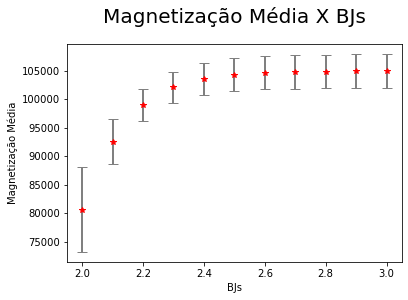

In [115]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

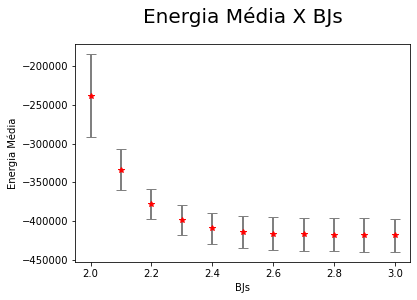

In [116]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

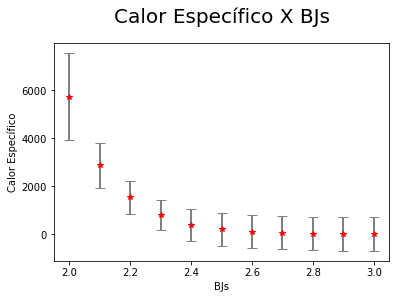

In [117]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

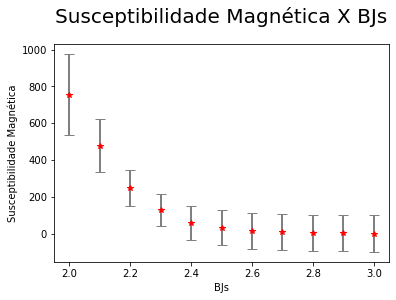

In [118]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $24^2$:</font>

<font size="5"> Sempre ao mudar o tamanho linear, para usar o numba, visando eficiência, é necessário redefinir as funções do algortimo de metropolis. </font>

In [119]:
tipo = 5
N = 24**2

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


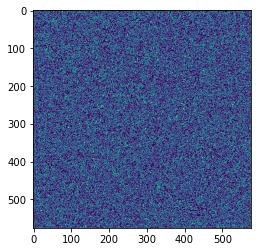

In [121]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)

ms = np.zeros((len(BJs),n))
Es = np.zeros((len(BJs),n))
Cvs = np.zeros((len(BJs),n))
chis = np.zeros((len(BJs),n))

In [122]:
for i, bj in enumerate(reversed(BJs)):  
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    for caixas in reversed(range(n)): 
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [124]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean()
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[i] - ms[BJ][i] )**2
        ESoma += ( EBarra[i] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[i] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[i] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

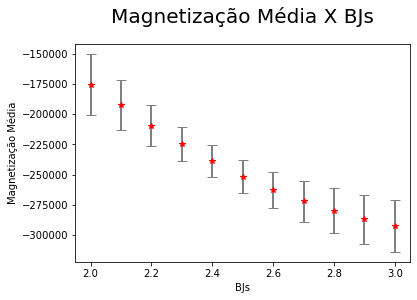

In [127]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

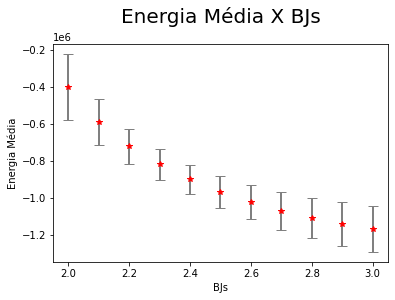

In [128]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

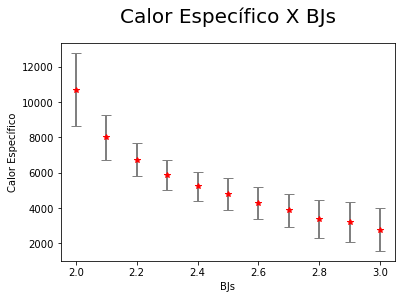

In [129]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

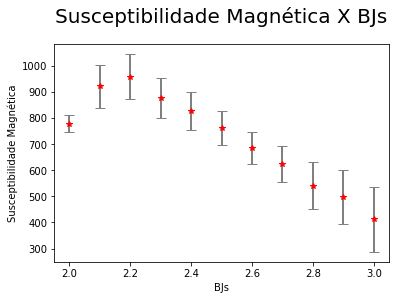

In [130]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Façamos a simulação para uma malha de tamanho linear = $36^2$: </font>

In [132]:
tipo = 5
N = 36**2

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


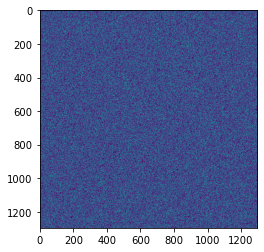

In [133]:
malha = cria_malhas(N,5) #primeira malha aleatória
plt.imshow(malha)
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

In [134]:
for i, bj in enumerate(reversed(BJs)):  
    if i == 0:
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        malha_lin = metropolisArr(malha, passosMC, bj, get_energy(malha))
    else:
        spins, energies = metropolis(malha_lin, passosMC, bj, get_energy(malha_lin))
        malha_lin = metropolisArr(malha_lin, passosMC, bj, get_energy(malha_lin))
    for caixas in reversed(range(n)): 
        if caixas > 0:
            ms[i][caixas] = spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].mean()
            Es[i][caixas] = energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) * (caixas + 1) : - int(1e4) * caixas].std()
        elif caixas == 0:
            ms[i][caixas] = spins[- int(1e4) : ].mean()
            Es[i][caixas] = energies[- int(1e4) : ].mean()
            Cvs[i][caixas] = BJs[i] * BJs[i] * energies[- int(1e4) : ].std()
            chis[i][caixas] = BJs[i] * spins[- int(1e4) : ].std()

In [2]:
#print(f"{ms}\n{Es}\n{Cvs}\n{chis}")

In [137]:
mBarra = np.zeros((len(BJs)))
EBarra = np.zeros((len(BJs)))
CvBarra = np.zeros((len(BJs)))
chiBarra = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mBarra[BJ] = ms[BJ].mean()
    EBarra[BJ] = Es[BJ].mean()
    CvBarra[BJ] = Cvs[BJ].mean()
    chiBarra[BJ] = chis[BJ].mean()

mErr = np.zeros((len(BJs)))
EErr = np.zeros((len(BJs)))
CvErr = np.zeros((len(BJs)))
chiErr = np.zeros((len(BJs)))

for BJ in range(len(BJs)):
    mSoma = 0
    ESoma = 0
    CvSoma = 0
    chiSoma = 0
    for i in range(n):
        mSoma += ( mBarra[i] - ms[BJ][i] )**2
        ESoma += ( EBarra[i] - Es[BJ][i] )**2
        CvSoma += ( CvBarra[i] - Cvs[BJ][i] )**2
        chiSoma += ( chiBarra[i] - chis[BJ][i] )**2
    mErr[BJ] = np.sqrt( mSoma / (n * (n - 1)) )
    EErr[BJ] = np.sqrt( ESoma / (n * (n - 1)) )
    CvErr[BJ] = np.sqrt( CvSoma / (n * (n - 1)) )
    chiErr[BJ] = np.sqrt( chiSoma / (n * (n - 1)) )

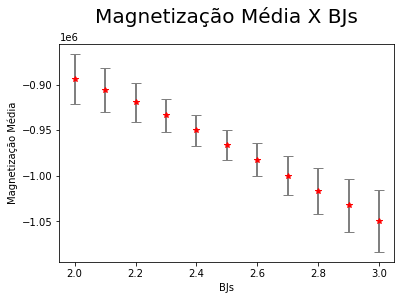

In [138]:
fig = plt.errorbar(BJs, mBarra, mErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Magnetização Média')
plt.title("Magnetização Média X BJs",  y=1.07, size=20)
plt.show()

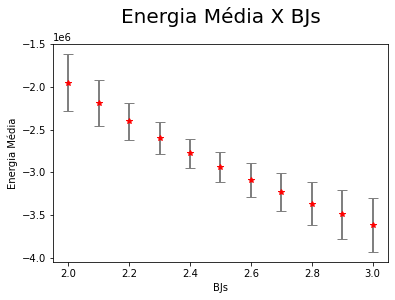

In [139]:
fig = plt.errorbar(BJs, EBarra, EErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Energia Média')
plt.title("Energia Média X BJs",  y=1.07, size=20)
plt.show()

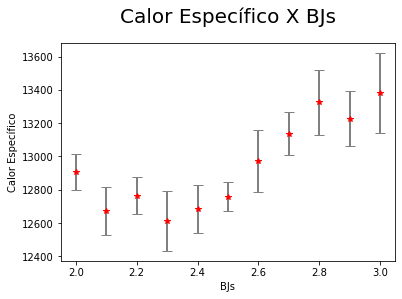

In [140]:
fig = plt.errorbar(BJs, CvBarra, CvErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Calor Específico')
plt.title("Calor Específico X BJs",  y=1.07, size=20)
plt.show()

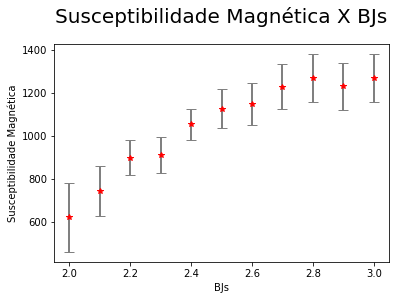

In [141]:
fig = plt.errorbar(BJs, chiBarra, chiErr, fmt = '*', color = 'red', ecolor = 'grey', elinewidth = 2, capsize=5)
plt.xlabel('BJs')
plt.ylabel('Susceptibilidade Magnética')
plt.title("Susceptibilidade Magnética X BJs",  y=1.07, size=20)
plt.show()

<font size="5"> Para o tamanho linear da malha = $48^2$, o tempo de execução da simulação se torna muito longo. </font>

<font size="5"> Conclusões: </font>

Observamos que, a medida que o sistema aumenta os erros estatísticos tendem a aumentar. Então, para uma abstração de uma malha infinita, é de se esperar que haja um erro infinito, sendo assim, impossível prever de fato as grandezas do sistema. 

Além disso, vemos que, qualitivamente, os erros estatísticos tender a diminiur com o aumento de $\beta \cdot J$. Ou seja, em uma temperatura maior, os erros são maiores. Uma possível razão para isso é que o aumento da energia do sistema o deixa mais sucetível à mudanças.

<font size="5"> Voltamos o tamanho linear para 48 e digressamos sobre o fenômeno da mudança de fases para duas malhas: Uma com 75% dos spins positivos e outra com 75% dos spins negativos:</font>

In [35]:
tipo = 5
N = 48

@numba.njit("UniTuple(f8[:], 2)(f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolis(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    net_spins = np.zeros(times-1)
    net_energy = np.zeros(times-1)
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
        net_spins[t] = spin_arr.sum()
        net_energy[t] = energy
    return net_spins, net_energy

@numba.njit("f8[:,:](f8[:,:], i8, f8, f8)", nopython=True, nogil=True)
def metropolisArr(spin_arr, times, BJ, energy):
    times = int(times)
    spin_arr = spin_arr.copy()
    for t in range(0,times-1):
        x = np.random.randint(0,N)
        y = np.random.randint(0,N)
        spin_i = spin_arr[x,y] 
        spin_f = spin_i*-1 
        E_i = 0
        E_f = 0
        if x>0:
            E_i += -spin_i*spin_arr[x-1,y]
            E_f += -spin_f*spin_arr[x-1,y]
        if x<N-1:
            E_i += -spin_i*spin_arr[x+1,y]
            E_f += -spin_f*spin_arr[x+1,y]
        if y>0:
            E_i += -spin_i*spin_arr[x,y-1]
            E_f += -spin_f*spin_arr[x,y-1]
        if y<N-1:
            E_i += -spin_i*spin_arr[x,y+1]
            E_f += -spin_f*spin_arr[x,y+1]
        dE = E_f-E_i
        if (dE>0)*(np.random.random() < np.exp(-BJ*dE)):
            spin_arr[x,y]=spin_f
            energy += dE
        elif dE<=0:
            spin_arr[x,y]=spin_f
            energy += dE
    return spin_arr

/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/gui/anaconda3/lib/python3.8/site-packages/numba/core/decorators.py:255: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [36]:
malhaP = cria_malhas(N,4)
malhaN = cria_malhas(N,3)

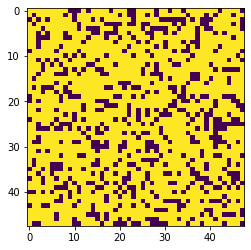

In [37]:
plt.imshow(malhaP)

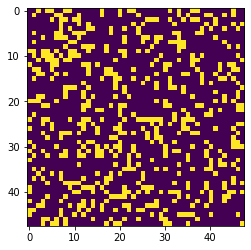

In [38]:
plt.imshow(malhaN)

<font size="5"> Encontraremos valores médios para a energia e magnetização, suposto atigindo a termalização, para dada uma temperatura BJ, e realizamos uma média nos últimos 100,000 passos de Monte Carlo.  </font>

In [39]:
def getSEBarra(malha, BJs, passosMC):
    mBarra = np.zeros(len(BJs))
    EBarra = np.zeros(len(BJs))
    EStds = np.zeros(len(BJs)) #standard deviation
    for i, bj in enumerate(BJs):
        spins, energies = metropolis(malha, passosMC, bj, get_energy(malha))
        mBarra[i] = spins[- int(1e5):].mean()
        EBarra[i] = energies[- int(1e5):].mean()
        EStds[i] = energies[- int(1e5):].std()
    return mBarra, EBarra, EStds

In [40]:
passosMC = 1e6
BJs = np.arange(0.1, 2, 0.05)
mBarraP, EBarraP, EStdsP = getSEBarra(malhaP, BJs, passosMC)
mBarraN, EBarraN, EStdsN = getSEBarra(malhaN, BJs, passosMC)

<font size="5"> Podemos olhar $\bar{m}$ como função da temperatura $T = 1/\beta = J/(\beta J)$ </font>

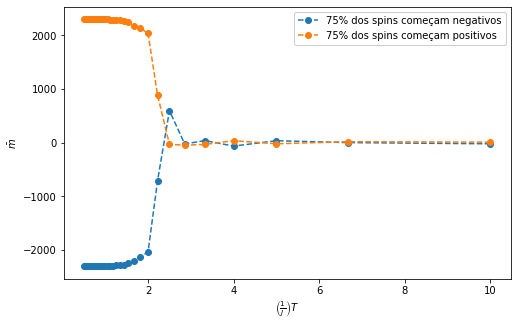

In [43]:
plt.figure(figsize=(8,5))
plt.plot(1/BJs, mBarraN, 'o--', label='75% dos spins começam negativos')
plt.plot(1/BJs, mBarraP, 'o--', label='75% dos spins começam positivos')
plt.xlabel(r'$\left(\frac{1}{J}\right)T$')
plt.ylabel(r'$\bar{m}$')
plt.legend(facecolor='white', framealpha=1)
plt.show()

O gráfico acima exibe a variação do spin médio $\overline{m}$ com aumento da temperatura $\frac{T}{J}$. Dele, podemos concluir que, se a temperatura está baixa o suficiente, qualitivamente, abaixo de 2, a malha fica magnetizada, i.e., os spins que estão em minoria tendem a se alinhar com os spins que estão em maioria. Por outro lado, se a temperatura está alta o suficiente, qualitativamente, acima de 3, a malha perde sua magnetização, i.e., os spins se alinham de tal forma que $\overline{m} = 0$. Disso, é de se esperar que a malha passe por uma mudança de fase quando a temperatura entre 2 e 3.